In [946]:
import zipfile
import os
import preprocessing as ppg
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from random import randint
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor

pd.options.mode.chained_assignment = None

import warnings
warnings.filterwarnings("ignore")

# Распаковка

In [563]:
def unpack_data(zip_file: str, data_list: list) -> None:
    with zipfile.ZipFile(f'{zip_file}.zip', 'r') as zipFile:
        zipFile.extractall()
    for mode in data_list:
        dealsList = os.listdir(f'data/{mode}/{mode}_deals')
        for deals in dealsList:
            with zipfile.ZipFile(f'data/{mode}/{mode}_deals/{deals}', 'r') as zipFile:
                zipFile.extractall(f'data/{mode}/{mode}_deals')
            os.remove(f'data/{mode}/{mode}_deals/{deals}')
    return None

In [564]:
# В каких папках распаковать deals
DATA_LIST = ['train', 'test']

In [565]:
unpack_data('data', DATA_LIST)

# Препроцессинг

In [566]:
ppg.format_main('train', True)
ppg.format_main('test', False)

In [567]:
for mode in ['train', 'test']:
    path = f'data/{mode}/{mode}.csv'
    main = pd.read_csv(path, sep = ',')
    ids = main['id']
    for id in ids:
        ppg.format_account_condition(id, mode)
        ppg.format_reference_point(id, mode)
        for i in range(1, 4):
            ppg.format_deals(id, i, mode)

# Чтение и обработка данных

In [936]:
def additional_data_to_dict(mode: str, main_df: pd.DataFrame) -> dict:
    data = dict()
    ids = main_df.id
    for id in ids:
        acc_conf = f'data/{mode}/{mode}_additional_info/id_{id}/account_condition_{id}.csv'
        ref_point = f'data/{mode}/{mode}_additional_info/id_{id}/reference_point_{id}.csv'
        stat_table = f'data/{mode}/{mode}_additional_info/id_{id}/stats_table_{id}.csv'
        deals_1 = f'data/{mode}/{mode}_deals/1_{id}.csv'
        deals_2 = f'data/{mode}/{mode}_deals/2_{id}.csv'
        deals_3 = f'data/{mode}/{mode}_deals/3_{id}.csv'
        data[id] = {
                  'account_condition': pd.read_csv(acc_conf) if os.path.exists(acc_conf) else None, 
                  'reference_point': pd.read_csv(ref_point) if os.path.exists(ref_point) else None, 
                  'stats_table': pd.read_csv(stat_table, sep=';') if os.path.exists(stat_table) else None,
                  'deals': pd.read_csv(deals_1, index_col=0) if os.path.exists(deals_1) 
                                else pd.read_csv(deals_2, index_col=0) if os.path.exists(deals_2)
                                else pd.read_csv(deals_3, index_col=0) if os.path.exists(deals_3)
                                else None
                                
                }
    return data

In [569]:
def drop_outlier(df: pd.DataFrame, lower_quantile: float, upper_quantile: float):
    columns = ['start_sum', 'income_percent', 'deals']

    # Словари для хранения нижних и верхних границ для каждого столбца
    lower_bounds = {}
    upper_bounds = {}

    # Вычисление нижних и верхних границ для каждого столбца
    for col in columns:
        Q1 = df[col].quantile(lower_quantile)
        Q3 = df[col].quantile(upper_quantile)
        IQR = Q3 - Q1
        lower_bound = Q1 - 2.0 * IQR
        upper_bound = Q3 + 2.0 * IQR
        lower_bounds[col] = lower_bound
        upper_bounds[col] = upper_bound

    # Создаем фильтр для удаления выбросов по вычисленным границам
    mask = pd.Series(True, index=df.index)
    for col in columns:
        mask = mask & (df[col] >= lower_bounds[col]) & (df[col] <= upper_bounds[col])

    # Применяем фильтр к датафрейму
    df_filtered = df[mask]
    df = df_filtered
    return df

In [1216]:
# Cловарь с таблицами всех юзеров из трейна и из теста
train = pd.read_csv('data/train/train.csv', sep = ',', index_col=0).drop(columns = 'broker')
# train = drop_outlier(train, 0.1, 0.9)
train['income_percent'].fillna(train.income_rub/train.start_sum, inplace = True)

test = pd.read_csv('data/test/test.csv', sep = ',', index_col=0).drop(columns = 'broker')

In [937]:
# Cловарь с таблицами всех юзеров из трейна и из теста
data = dict()

data.update(additional_data_to_dict('train', train))
data.update(additional_data_to_dict('test', test))

# Feature engineering

In [210]:
def adding_deal_sum_info(df: pd.DataFrame) -> pd.DataFrame:
    df['mean_deal_sum'] = 0
    df['std_deal_sum'] = 0
    df['len_deals'] = 0
    for id in df.id:
        table = data[id]['deals']
        if table is not None:
            df.mean_deal_sum.loc[df.id == id] = table.summ.mean()
            std = table.summ.std()
            df.std_deal_sum.loc[df.id == id] = std if not np.isnan(std) else 0
            df.len_deals.loc[df.id == id] = len(table)

    non_zero_rows = df[df['mean_deal_sum'] != 0].drop(columns = ["nickname", "id", "std_deal_sum", "class"])
    lin_reg = LinearRegression()
    lin_reg.fit(non_zero_rows.drop(columns = ['mean_deal_sum']), non_zero_rows['mean_deal_sum'])
    zero_rows = df[df['mean_deal_sum'] == 0].drop(columns = ["nickname", "id", "std_deal_sum", "class"])
    predicted_values = lin_reg.predict(zero_rows.drop(columns = ['mean_deal_sum']))
    df.loc[df['mean_deal_sum'] == 0, 'mean_deal_sum'] = predicted_values
    
    non_zero_rows = df[df['std_deal_sum'] != 0].drop(columns = ["nickname", "id", "class"])
    lin_reg = LinearRegression()
    lin_reg.fit(non_zero_rows.drop(columns = ['std_deal_sum']), non_zero_rows['std_deal_sum'])
    zero_rows = df[df['std_deal_sum'] == 0].drop(columns = ["nickname", "id", "class"])
    predicted_values = lin_reg.predict(zero_rows.drop(columns = ['std_deal_sum']))
    df.loc[df['std_deal_sum'] == 0, 'std_deal_sum'] = predicted_values
    
    return df

In [1089]:
def adding_frequent_market_info(df: pd.DataFrame) -> pd.DataFrame:
    df['stock_coef'] = 0
    df['curr_coef'] = 0
    df['fort_coef'] = 0
    # df['freq_market'] = 0
    
    df['income_percent_stats'] = 0 
    
    for id in df.id:
        table = data[id]['stats_table']
        if table is not None:
            
            # market coefs
            stock_turnover = table.loc[1, 'part_turnover'] if table.loc[1, 'part_turnover'] != '-' else 0
            curr_turnover = table.loc[3, 'part_turnover']  if table.loc[3, 'part_turnover'] != '-' else 0
            fort_turnover = table.loc[2, 'part_turnover']  if table.loc[2, 'part_turnover'] != '-' else 0
            
            df.stock_coef.loc[df.id == id] = float(stock_turnover) 
            df.curr_coef.loc[df.id == id] = float(curr_turnover) 
            df.fort_coef.loc[df.id == id] = float(fort_turnover) 
            
            # df.freq_market.loc[df.id == id] = \
            #             max(enumerate([0, float(stock_turnover), float(curr_turnover), float(fort_turnover)]),key=lambda x: x[1])[0]
                            
            # income 
            df.income_percent_stats.loc[df.id == id] = table.loc[0, "income_percent"]
    
    return df.fillna(0)



In [212]:
def adding_free_funds_info(df: pd.DataFrame) -> pd.DataFrame:
    df['std_free_funds'] = 0
    df['coef_free_funds'] = 0
    df['coef_free_funds2'] = 0
    df['mean_free_funds'] = 0
    df['min_free_funds'] = 0
    df['max_free_funds'] = 0
    
    for id in df.id:
        table = data[id]['account_condition']
        if table is not None:
            std = (table.free_funds).std()
            df.std_free_funds.loc[df.id == id] = std
            
            if len(table)<1:
                df.coef_free_funds.loc[df.id == id] = 0
                df.coef_free_funds2.loc[df.id == id] = 0
            else:
                df.coef_free_funds.loc[df.id == id] = \
                                    std / table.start_sum.iloc[0]
                df.coef_free_funds2.loc[df.id == id] = \
                                    (std / table.start_sum.iloc[0])**2
            
            df.mean_free_funds.loc[df.id == id] = np.mean(table.free_funds)
            df.max_free_funds.loc[df.id == id] = np.max(table.free_funds)
            df.min_free_funds.loc[df.id == id] = np.min(table.free_funds)
            
    
    return df

In [213]:
def adding_features(df: pd.DataFrame) -> pd.DataFrame:
    df = adding_deal_sum_info(df)
    df = adding_frequent_market_info(df)
    df = adding_free_funds_info(df)
    return df

In [220]:
train = adding_features(train)

# Embeddings

In [283]:
def random_embedding(vec, fix_size):
    emb = [vec[randint(0, len(vec)-1)] for _ in range(fix_size)]
    return emb

In [284]:
def sort_dist_embedding(vec, fix_size):
    '''
    making a fix_size embedding by selecting far values after vector sorting
    
    parameters: vec - pca vector, fix_size - size for embedding
    returns: emb - fix_size embedding
    '''
    
    emb = [sorted(vec)[i*(len(vec)//(fix_size-1)) if i!=fix_size-1 else -1] for i in range(fix_size)]
    return emb

In [285]:
def distribution_discription_embedding(vec):
    emb = [np.mean(vec), np.std(vec), pd.Series(vec).skew(), pd.Series(vec).kurt()]
    return emb

In [286]:
def approximation_embedding(vec, fix_size):
    emb = [ np.mean( sorted(vec)[(i-1)*(len(vec)//(fix_size-1)) : (i*(len(vec)//(fix_size-1)) \
                                                                 if i!=fix_size-1 else -1)] )  \
                                                                 for i in range(1, fix_size+1) ]

    emb = [i if not np.isnan(i) else 0 for i in emb]
    return emb

In [1118]:
def making_vector(table):
    # prepro
    table = table.drop(columns = ["ticker"])
    table['datetime'] = pd.to_datetime(table['datetime'])
    table['datetime'] = table['datetime'].apply(lambda x: x.timestamp())

    # PCA vector 
    pca = PCA(n_components=1)
    scaler = StandardScaler().fit_transform(table)
    vector = pca.fit_transform(scaler)
    vector = [i[0] for i in vector]
    return vector

In [1119]:
def adding_embeddings(dataset, fix_size = 5):
    '''
    adding embedding of additional tables to main dataframe
    
    parameters: dataset - pd.DataFrame (dataset for adding features)
    returns: dataset - pd.DataFrame (dataset with new columns)
    '''
    
    for i in range(fix_size):
        dataset[f"emb{i}"] = 0
        
    for id in dataset.id:
        table = data[id]['deals']
        
        if table is not None:
            # vec
            vec = making_vector(table)
            
            # embs
            emb = sort_dist_embedding(vec, fix_size)
            
            # adding emb to dataset 
            dataset.loc[dataset.id==id, "emb0":f"emb{fix_size-1}"] = emb

    return dataset
    


In [712]:
train = adding_embeddings(train, 12)

# Соединение таблиц

In [1212]:
norm_border(2)

0.0400185816707288

In [1213]:
def norm_border(dlen):
    return -np.exp(1)**(-0.03*dlen+1) + 2.6

In [1214]:
def concat_deals(dataset, norm_parameter):
    deals = pd.DataFrame([])
    for id in dataset.id:
        table = data[id]['deals']
        if table is not None:

            vec = making_vector(data[id]['deals']) 
            if len(vec)>1:
                # нормализуем вектор (множитель - гиперпараметр)
                vec = ((vec - min(vec))/(max(vec)-min(vec))-0.5) * norm_border(len(table))
            
            table['rclass'] = dataset[dataset.id==id]['class'].values + vec

            table["id"] = id # добавляем id для соединения дилсов с юзером

            deals = pd.concat([ deals, table ], ignore_index=True) if len(deals)!=0 else table # конкатим все дилсы в один датасет
        else: 
            # если таблиц deals нет, добавляем дефолтную строку
            deals.loc[deals.shape[0]] = [datetime.strptime("2022-09-22 14:40:00.000", '%Y-%m-%d %H:%M:%S.%f'), 0, 0, 0, id, *dataset[dataset.id==id]['class'].values]
        
    dataset = pd.merge(deals, dataset, on ='id') # мерджим датасет со сделками по id 
    return dataset

In [1215]:
def droping_col(dataset):
    dataset['datetime'] = pd.to_datetime(dataset['datetime'])
    dataset['datetime'] = dataset['datetime'].apply(lambda x: x.timestamp())
    return dataset.drop(["class", "rclass"], 1)

In [1144]:
def split_with_deals(dataset, norm_parameter, train_size):
    # делим на train и test
    X = train.drop(columns = ["nickname"])
    y = train["class"]
    X_train, X_test, y_train1, y_test = train_test_split(X, y, random_state=42, train_size = train_size)

    # добавляем сделки в датасет
    X_train = concat_deals(X_train, norm_parameter)
    X_test = concat_deals(X_test, norm_parameter)
    
    y_train = X_train.rclass

    # удаляем лишние признаки
    X_train = droping_col(X_train)
    X_test = droping_col(X_test)
    
    return X_train, X_test, y_train, y_test

In [1145]:
def y_downsampling(model_predictions, dataset):
    id_len = {id: len(data[id]['deals'] if data[id]['deals'] is not None else [0]) for id in dataset.id}
    y_pred = []
    i = 0
    for id in dataset.id.unique():

        # считаем среднее по классам юзера
        mean_y = np.mean( model_predictions[i:i+id_len[id]]) 

        # обработка выхода за границу
        if mean_y > 5: mean_y = 5 
        if mean_y < 1: mean_y = 1

        # добавляем итоговый класс юзера (средний от всех)
        y_pred = np.append(y_pred, round(mean_y))
        i+=id_len[id]

    return y_pred

# Обучение моделей

In [1217]:
EMB_SIZE = 16

# добавление фич из доп таблиц
train = adding_features(train) 

# создание эмбедингов
# train = adding_embeddings(train, EMB_SIZE)

In [1151]:
def my_train_test_split(train, train_size = 0.75, with_deals = 0, norm_par= 1):
    if with_deals:
        X_train, X_test, y_train, y_test = split_with_deals(train, norm_par, train_size)
    else:
        X = train.drop(columns = ["class", "nickname", "id"])
        y = train["class"]
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size = train_size)

    return X_train, X_test, y_train, y_test

In [1218]:
NORM_PAR = 0.8
WITH_DEALS = 1

# сплит датасета
X_train, X_test, y_train, y_test = my_train_test_split(train, with_deals = WITH_DEALS, norm_par = NORM_PAR)

In [1221]:
def model_training(X_train, y_train, with_deals = 0):
    # cat_columns = X_train.select_dtypes(include=['object']).columns

    if with_deals: 
        model = CatBoostRegressor(verbose=0, loss_function='RMSE')
        score = 'neg_mean_squared_error'
    else: 
        model = CatBoostClassifier(verbose=0, loss_function='MultiClass')
        score = 'f1_macro'

    param_grid = {'iterations': [500, 1000, 300],
        'learning_rate': [0.05, 0.1],
        'depth': [4, 5],
        "l2_leaf_reg": [15, 35, 60]}

    grid_search = RandomizedSearchCV(estimator=model, 
                                    param_distributions=param_grid, 
                                    cv=5, 
                                    scoring=score, 
                                    n_iter=6)

    grid_search.fit(X_train, y_train)

    print("Best Parameters:", grid_search.best_params_)
    print("Best CV Score:", grid_search.best_score_)

    results = grid_search.cv_results_
    print("Results of all configurations", results['mean_test_score'])

    return grid_search

In [1222]:
grid_search = model_training(X_train, y_train, with_deals = WITH_DEALS)
model = grid_search.best_estimator_

Best Parameters: {'learning_rate': 0.05, 'l2_leaf_reg': 35, 'iterations': 500, 'depth': 5}
Best CV Score: -0.605968292759814
Results of all configurations [-0.60596829 -0.63137455 -0.63272101 -0.66286697 -0.61301883 -0.64548517]


In [ ]:
grid_search1 = model_training(X_train, y_train, with_deals = WITH_DEALS)
model1 = grid_search.best_estimator_

In [1223]:
def calculate_metrics(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    f1 = f1_score(y_true, y_pred, average = 'micro')
    return rmse, f1

In [1229]:
def model_predict(model, X_train, X_test):
    y_pred_ts = model.predict(X_test)
    y_pred_tr = model.predict(X_train)
    return y_pred_ts, y_pred_tr

In [1230]:
def metrics(cbc, X_train, X_test, y_train, y_test, with_deals = 0):
    '''
    calculation of metrics f1-score and RMSE
    
    parameters: y_true - series of right classes, y_pred - series of predicted classes
    returns: rmse, f1 - tuple of metrics
    '''
    y_pred_ts, y_pred_tr = model_predict(cbc, X_train, X_test)
    
    if with_deals:
        metrics_tr = calculate_metrics(y_downsampling(y_train, X_train), y_downsampling(y_pred_tr, X_train))
        metrics_ts = calculate_metrics(y_test, y_downsampling(y_pred_ts, X_test))

    else: 
        metrics_tr = calculate_metrics(y_train, y_pred_tr)
        metrics_ts = calculate_metrics(y_test, y_pred_ts)

    print(f"TRAIN: \nrmse:{metrics_tr[0]}\nf1: {metrics_tr[1]}\nTEST: \nrmse:{metrics_ts[0]}\nf1: {metrics_ts[1]}")
    return metrics_tr, metrics_ts

In [1226]:
metrics_tr, metrics_ts = metrics(model, X_train, X_test, y_train, y_test, with_deals = WITH_DEALS)

TRAIN: 
rmse:0.6099609837905412
f1: 0.6777292576419214
TEST: 
rmse:0.7942858757122784
f1: 0.5261780104712042


In [1227]:
for i, k in zip(model.get_feature_importance(), X_train.columns):
    print(i, k)

2.4122492043047563 datetime
1.4936351814144013 ticker
2.404618517336455 quantity
7.522962541569205 summ
21.25168626162408 id
1.7916694821834749 start_sum
1.1947029693536464 request
1.653423058758609 deals
1.2311611875091815 income_rub
0.038167834880491504 income_percent
1.422744074700954 mean_deal_sum
20.365120625467085 std_deal_sum
3.9031772376514176 len_deals
4.986929594514319 stock_coef
7.809658312300317 curr_coef
1.3582028929253889 fort_coef
3.137652406948992 income_percent_stats
0.8467091994117816 std_free_funds
2.3724513607922666 coef_free_funds
0.6816426724855806 coef_free_funds2
0.6602208477111668 mean_free_funds
1.0255714359007573 min_free_funds
0.7230768306983839 max_free_funds


<AxesSubplot:>

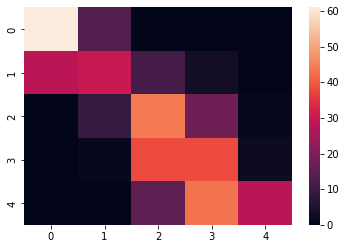

In [1239]:
sns.heatmap(confusion_matrix(y_test, y_downsampling(model_predict(model, X_train, X_test)[0], X_test)))

# Сравнение результатов

In [1202]:
discription = f"train + FE + EMB{EMB_SIZE}(sort_dist)3"+f" + DEALS(rmse, n={NORM_PAR}"*WITH_DEALS

In [1203]:
config_comparing = pd.read_csv("model_configs.csv", index_col=0)

In [1204]:
config_comparing.loc[config_comparing.shape[0]] = [discription, *metrics_tr, *metrics_ts, *grid_search.best_params_.values()]

In [1205]:
config_comparing

,discription,rmse_train,f1_train,rmse_test,f1_test,lr,reg,iter,dep
0,train,0.845228,0.649990,0.825002,0.600992,0.05,20,300,5
1,train + FE,0.544925,0.838737,0.705253,0.647709,0.05,20,1000,5
2,train + OUTL,0.768626,0.721425,0.847891,0.600807,0.05,10,500,5
3,train + EMB10(rand),0.758072,0.726841,0.908079,0.544261,0.05,20,500,4
4,train + EMB4(dist_discr),0.809874,0.673316,0.865269,0.587446,0.05,10,300,4
5,train + EMB10(approc),0.789118,0.694424,0.872800,0.584053,0.05,10,300,4
6,train + EMB10(sort_dist),0.831687,0.672513,0.875794,0.579620,0.05,20,300,4
7,train + EMB25(approc),0.794633,0.717275,0.862239,0.578924,0.05,10,300,5
8,train + EMB16(approc),0.776286,0.735163,0.848466,0.604577,0.05,10,500,4
9,train + EMB21(approc),0.814712,0.704075,0.857672,0.594055,0.05,20,500,4


In [1206]:
config_comparing.to_csv("model_configs.csv")

# Мусорка

In [1070]:
np.array(y_test).astype(np.float64)

array([5., 5., 2., 1., 2., 1., 3., 2., 5., 3., 3., 1., 1., 1., 1., 5., 3.,
       1., 1., 3., 1., 4., 2., 2., 4., 2., 5., 5., 5., 2., 3., 5., 2., 1.,
       4., 3., 5., 4., 5., 3., 3., 3., 4., 5., 3., 4., 1., 4., 2., 3., 4.,
       1., 4., 4., 3., 1., 5., 4., 3., 1., 5., 1., 1., 4., 5., 1., 4., 5.,
       1., 1., 4., 2., 5., 5., 3., 1., 3., 4., 1., 3., 2., 4., 4., 5., 2.,
       1., 1., 1., 4., 2., 5., 5., 3., 5., 1., 4., 5., 2., 3., 2., 5., 5.,
       4., 4., 2., 3., 4., 3., 4., 3., 1., 1., 5., 4., 5., 5., 5., 4., 1.,
       4., 1., 1., 4., 2., 1., 3., 4., 4., 2., 4., 3., 1., 4., 2., 2., 4.,
       4., 1., 4., 3., 3., 3., 1., 3., 2., 1., 3., 4., 5., 1., 4., 3., 3.,
       4., 1., 2., 4., 3., 1., 5., 2., 2., 2., 2., 1., 3., 1., 2., 5., 5.,
       4., 1., 5., 5., 5., 4., 2., 5., 4., 1., 2., 5., 1., 5., 5., 5., 3.,
       1., 1., 1., 1., 2., 5., 1., 3., 3., 4., 5., 2., 5., 2., 3., 4., 2.,
       4., 3., 2., 1., 4., 1., 3., 2., 4., 5., 1., 1., 4., 4., 4., 3., 5.,
       5., 3., 2., 5., 3.

In [1071]:
y_downsampling(y_pred_ts, X_test)

array([4., 4., 3., 1., 2., 2., 3., 2., 4., 3., 2., 1., 2., 1., 1., 4., 4.,
       2., 2., 3., 1., 4., 3., 2., 4., 2., 4., 3., 4., 2., 4., 4., 3., 1.,
       3., 3., 4., 4., 4., 3., 2., 3., 4., 4., 2., 4., 1., 4., 3., 3., 3.,
       2., 3., 4., 3., 1., 4., 4., 4., 1., 3., 1., 1., 3., 3., 2., 4., 3.,
       1., 1., 4., 2., 3., 3., 3., 1., 4., 3., 2., 4., 2., 4., 3., 3., 2.,
       1., 2., 1., 4., 2., 3., 3., 3., 4., 1., 4., 4., 2., 3., 2., 4., 3.,
       3., 3., 2., 4., 4., 3., 4., 4., 2., 2., 3., 3., 3., 3., 3., 3., 1.,
       3., 1., 2., 3., 2., 1., 3., 3., 3., 2., 4., 2., 1., 3., 2., 3., 4.,
       3., 2., 4., 3., 3., 4., 1., 3., 3., 1., 4., 4., 4., 2., 4., 3., 3.,
       4., 2., 2., 4., 4., 1., 3., 3., 2., 2., 2., 1., 3., 2., 3., 4., 4.,
       4., 1., 4., 3., 3., 3., 2., 4., 3., 1., 3., 3., 1., 3., 4., 3., 3.,
       1., 1., 2., 1., 2., 3., 1., 4., 3., 3., 4., 2., 3., 2., 3., 4., 2.,
       4., 4., 2., 2., 3., 1., 5., 2., 3., 3., 1., 2., 3., 4., 5., 3., 3.,
       3., 3., 1., 3., 2.

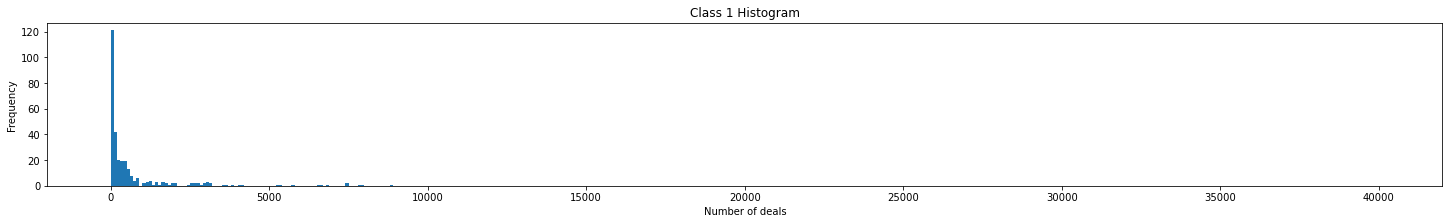

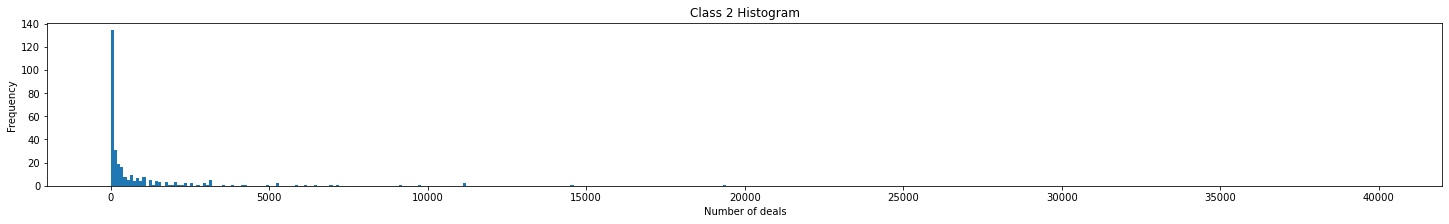

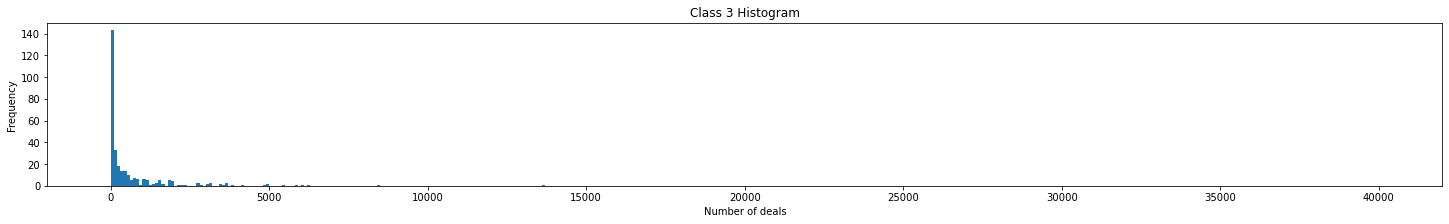

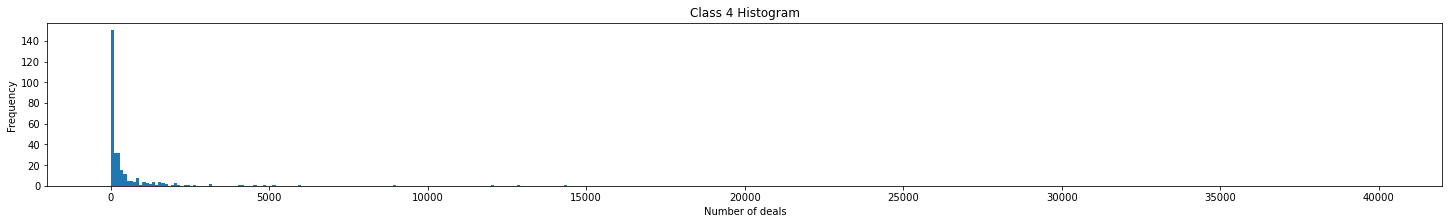

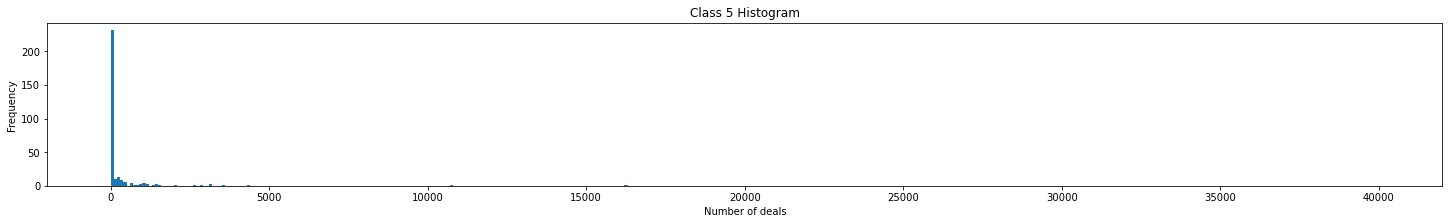

In [1026]:
import matplotlib.pyplot as plt

for clas in range(1, 6):
    l=[]
    for id in train[train['class']==clas].id:
        if data[id]['deals'] is not None:
            l.append(len(data[id]['deals']))
    fig, ax = plt.subplots(figsize=(25, 3))

    ax.hist(l, bins = len(set(l)), range=(0, 40000))
    ax.set_xlabel('Number of deals')
    ax.set_ylabel('Frequency')
    ax.set_title(f"Class {clas} Histogram")

    plt.show()

In [45]:
train = pd.merge(concat_deals(train), train, on ='id') # по id соединяем юзера с его deals 

In [829]:
# splitting train on train and test sets
X = train.drop(columns = ["class", "nickname", "id"])
y = train["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size = 0.75)

In [1130]:
cat_columns = X_train.select_dtypes(include=['object']).columns
model = CatBoostRegressor(verbose=0, loss_function='RMSE')

param_grid = {'iterations': [500, 1000, 300],
              'learning_rate': [0.05, 0.1],
              'depth': [4, 5],
              "l2_leaf_reg": [15, 35, 60]}

grid_search = RandomizedSearchCV(estimator=model, 
                                param_distributions=param_grid, 
                                cv=5, 
                                scoring='neg_mean_squared_error', 
                                n_iter=6)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

Best Parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 35, 'iterations': 300, 'depth': 5}
Best CV Score: -0.39768823524523433


In [719]:
%%time

cat_columns = X_train.select_dtypes(include=['object']).columns
model = CatBoostClassifier(verbose=0, loss_function='MultiClass')

param_grid = {'iterations': [500, 1000, 300],
              'learning_rate': [0.05, 0.1],
              'depth': [4, 5],
              "l2_leaf_reg": [4, 10, 20, 35]}

grid_search = RandomizedSearchCV(estimator=model, 
                                param_distributions=param_grid, 
                                cv=5, 
                                scoring='f1_macro', 
                                n_iter=10)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

Best Parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 20, 'iterations': 500, 'depth': 5}
Best CV Score: 0.6415932042350023
Wall time: 5min 25s


In [1131]:
cbc = grid_search.best_estimator_
results = grid_search.cv_results_
print("Results of all configurations", results['mean_test_score'])

Results of all configurations [-0.4100753  -0.40429761 -0.42660735 -0.40226572 -0.40152396 -0.39768824]


In [46]:
def my_train_test_split(df, random_state=42, train_size = 0.75):
    
    X_train, X_test = pd.DataFrame(columns = df.columns), pd.DataFrame(columns = df.columns)
    y_train, y_test = pd.Series([]), pd.Series([])
    
    while (len(X_train) / len(df)) < (train_size / (1-train_size)):
        unique_ids = df.id.unique() 
        rand_id = unique_ids[randint(0, len(unique_ids)-1)] # рандомный id юзера
        X_train = pd.concat([X_train, df[df.id==rand_id]], ignore_index=True) # добавляем в треин выборку операции этого юзера
        y_train = y_train + pd.Series([df[df.id == rand_id]['class'].values[0]] * id_len[rand_id])
        df.drop(df[df.id == rand_id].index, inplace = True) # удаляем операции юзера из датафрейма, который потом станет тестовым
    X_test = df.drop(columns = ["class", "nickname"])
    X_train = X_train.drop(columns = ["class", "nickname"])
    X_test = X_test[X_train.columns]
    y_test = df['class']
    return X_train, X_test, y_train, y_test

In [619]:
config_comparing = config_comparing.reset_index(drop=True)

In [46]:
def cv_metrics(cbc, X, y):
    y_pred = cbc.predict(X)
    f1_scores = cross_val_score(cbc, X, y, cv=5, scoring='f1_macro')
    nrmse = cross_val_score(cbc, X, y, cv=5, scoring='neg_root_mean_squared_error')
    print(f"RMSE: {-np.mean(nrmse)}\nF1: {f1_scores}")
    # return -nrmse.mean(), f1_score.mean()


In [47]:
cv_metrics(cbc, X_test, y_test)

RMSE: 0.8042710363397572
F1: [0.63636364 0.63636364 0.63157895 0.67105263 0.59210526]


In [ ]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred_ts)
score

In [ ]:
tables_counter = []

for mode in ["train", "test"]:
    ids = train.id if mode=="train" else final_test.id
    for id in ids:
        deals_1 = f'{DIRECTORY}data/{mode}/{mode}_deals/1_{id}.csv'
        deals_2 = f'{DIRECTORY}data/{mode}/{mode}_deals/2_{id}.csv'
        deals_3 = f'{DIRECTORY}data/{mode}/{mode}_deals/3_{id}.csv'
        tables_counter.append(os.path.exists(deals_1) + os.path.exists(deals_2) + os.path.exists(deals_3))
tables_counter.count(0)

In [ ]:
pd.Series(tables_counter).hist()

In [ ]:
tables_exists = []

for mode in ["train", "test"]:
    ids = train.id if mode=="train" else final_test.id
    for id in ids:
        deals_1 = f'{DIRECTORY}data/{mode}/{mode}_deals/1_{id}.csv'
        deals_2 = f'{DIRECTORY}data/{mode}/{mode}_deals/2_{id}.csv'
        deals_3 = f'{DIRECTORY}data/{mode}/{mode}_deals/3_{id}.csv'
        if os.path.exists(deals_1):
            tables_exists.append(1)
        if os.path.exists(deals_2):
            tables_exists.append(2)
        if os.path.exists(deals_3):
            tables_exists.append(3)
pd.Series(tables_exists).hist()

In [ ]:
len_deals_1 = []
len_deals_2 = []
len_deals_3 = []

for mode in ["train", "test"]:
    ids = train.id if mode=="train" else final_test.id
    for id in ids:
        deals_1 = f'{DIRECTORY}data/{mode}/{mode}_deals/1_{id}.csv'
        deals_2 = f'{DIRECTORY}data/{mode}/{mode}_deals/2_{id}.csv'
        deals_3 = f'{DIRECTORY}data/{mode}/{mode}_deals/3_{id}.csv'
        if os.path.exists(deals_1):
            len_deals_1.append(len(pd.read_csv(deals_1)))
        if os.path.exists(deals_2):
            len_deals_2.append(len(pd.read_csv(deals_2)))
        if os.path.exists(deals_3):
            len_deals_3.append(len(pd.read_csv(deals_3)))

In [ ]:
print(len(set(len_deals_1)), len([len_deals_1.count(i) for i in set(len_deals_1)]))

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize = (18, 8))
axes.plot(list(set(len_deals_1)), [len_deals_1.count(i) for i in set(len_deals_1)])
axes.plot(list(set(len_deals_2)), [len_deals_2.count(i) for i in set(len_deals_2)])
axes.plot(list(set(len_deals_3)), [len_deals_3.count(i) for i in set(len_deals_3)])
axes.set_xlabel("длина", fontsize = 16)
axes.set_ylabel("частота", fontsize = 16)
axes.legend(fontsize = 14)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_ts)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.scatter(adding_embedings(train)[0], adding_embedings(train)[1], [1])


In [ ]:
d_pca=[1, 2, 3, 4, 5, 6, 7, 8, 9]
fix_size = 4
[d_pca[i*(len(d_pca)//(fix_size-1)) if i!=fix_size-1 else -1] for i in range(fix_size)]

In [ ]:
account_condition.exist()

In [ ]:
a = w = i = 9
w+i

In [ ]:
test_additional_info_id_account_condition_list = []
test_additional_info_id_reference_point_list = []
test_additional_info_id_stats_table_list = []
test_deals_list = []

account_condition_list = []
reference_point_list = []
stats_table_list = []
test_deals_list = []
list_cnt_tables = []

main = pd.read_csv(f'/content/data/test/test.csv', sep = ',')
ids = main['id']

cnt_tables = 0
for id in ids:
    test_additional_info_id_account_condition_list.append(pd.read_csv(f'/content/data/test/test_additional_info/id_{id}/account_condition_{id}.csv'))
    test_additional_info_id_reference_point_list.append(pd.read_csv(f'/content/data/test/test_additional_info/id_{id}/reference_point_{id}.csv'))
    test_additional_info_id_stats_table_list.append(pd.read_csv(f'/content/data/test/test_additional_info/id_{id}/stats_table_{id}.csv', sep=';'))
    if not (pd.read_csv(f'/content/data/test/test_additional_info/id_{id}/account_condition_{id}.csv').empty):
        account_condition_list.append(1)
        cnt_tables += 1
    if not (pd.read_csv(f'/content/data/test/test_additional_info/id_{id}/reference_point_{id}.csv').empty):
        reference_point_list.append(1)
        cnt_tables += 1
    if not (pd.read_csv(f'/content/data/test/test_additional_info/id_{id}/stats_table_{id}.csv').empty):
        test_deals_list.append(1)
        cnt_tables += 1
    list_cnt_tables.append(cnt_tables)
    cnt_tables = 0

test_additional_info_id_account_condition = pd.concat(test_additional_info_id_account_condition_list, axis=0, join='outer', ignore_index=False, keys=ids)
test_additional_info_id_reference_point = pd.concat(test_additional_info_id_reference_point_list, axis=0, join='outer', ignore_index=False, keys=ids)
test_additional_info_id_stats_table = pd.concat(test_additional_info_id_stats_table_list, axis=0, join='outer', ignore_index=False, keys=ids)

# for id in ids:
#   test_deals_list.append(pd.read_csv(f'/content/data/test/test_deals/1_{id}.csv'))
# test_deals = pd.concat(test_deals_list, axis=0, join='outer', ignore_index=False, keys=ids)

distr_tables = pd.DataFrame({'id' : ids, 
                             'count_tables' : list_cnt_tables, 
                             })

distr_tables  

In [ ]:
test_additional_info_id_account_condition_list = []
test_additional_info_id_reference_point_list = []
test_additional_info_id_stats_table_list = []
test_deals_list = []

account_condition_list = []
reference_point_list = []
stats_table_list = []
test_deals_list = []
list_cnt_tables = []

main = pd.read_csv(f'/content/data/test/test.csv', sep = ',')
ids = main['id']

cnt_tables = 0
for id in ids:
  test_additional_info_id_account_condition_list.append(pd.read_csv(f'/content/data/test/test_additional_info/id_{id}/account_condition_{id}.csv'))
  test_additional_info_id_reference_point_list.append(pd.read_csv(f'/content/data/test/test_additional_info/id_{id}/reference_point_{id}.csv'))
  test_additional_info_id_stats_table_list.append(pd.read_csv(f'/content/data/test/test_additional_info/id_{id}/stats_table_{id}.csv', sep=';'))
  if not (pd.read_csv(f'/content/data/test/test_additional_info/id_{id}/account_condition_{id}.csv').empty):
    account_condition_list.append(1)
    cnt_tables += 1
  if not (pd.read_csv(f'/content/data/test/test_additional_info/id_{id}/reference_point_{id}.csv').empty):
    reference_point_list.append(1)
    cnt_tables += 1
  if not (pd.read_csv(f'/content/data/test/test_additional_info/id_{id}/stats_table_{id}.csv').empty):
    test_deals_list.append(1)
    cnt_tables += 1
  list_cnt_tables.append(cnt_tables)
  cnt_tables = 0

test_additional_info_id_account_condition = pd.concat(test_additional_info_id_account_condition_list, axis=0, join='outer', ignore_index=False, keys=ids)
test_additional_info_id_reference_point = pd.concat(test_additional_info_id_reference_point_list, axis=0, join='outer', ignore_index=False, keys=ids)
test_additional_info_id_stats_table = pd.concat(test_additional_info_id_stats_table_list, axis=0, join='outer', ignore_index=False, keys=ids)

# for id in ids:
#   test_deals_list.append(pd.read_csv(f'/content/data/test/test_deals/1_{id}.csv'))
# test_deals = pd.concat(test_deals_list, axis=0, join='outer', ignore_index=False, keys=ids)

distr_tables = pd.DataFrame({'id' : ids, 
                             'count_tables' : list_cnt_tables, 
                             })

distr_tables

In [ ]:
test_additional_info_id_account_condition.head()

In [ ]:
# много пропусков
test_additional_info_id_account_condition.info()

In [ ]:
# много пропусков
test_additional_info_id_reference_point.info()

In [ ]:
# много пропусков
test_additional_info_id_stats_table.info()

In [ ]:
test_additional_info_id_account_condition.sum(level='id')